In [1]:
import os
import json
from torch_geometric.data import HeteroData
import torch
import pickle

# Step 1: Parse the PHEME File Structure
def parse_pheme(base_path):
    data = []  # List to hold all graph data
    count = 0
    for event in os.listdir(base_path):
        event_path = os.path.join(base_path, event)
        
        if not os.path.isdir(event_path):
            continue  # Skip non-directory files like .DS_Store
        for label_type in ['rumours', 'non-rumours']:
            label = 0 if label_type == 'rumours' else 1  # Encode rumor: 0, non-rumor: 1
            label_path = os.path.join(event_path, label_type)
            if not os.path.isdir(label_path):
                continue  # Skip if not a directory
            for graph_id in os.listdir(label_path):
                graph_path = os.path.join(label_path, graph_id)
                if not os.path.isdir(graph_path):
                    continue  # Skip non-directory files
                annotation_file = os.path.join(graph_path, "annotation.json")
                source_tweet_path = os.path.join(graph_path, "source-tweets")
                reactions_path = os.path.join(graph_path, "reactions")
                structure_file = os.path.join(graph_path, "structure.json")

                data.append({
                    "graph_id": graph_id,
                    "label": label,
                    "annotation": annotation_file,
                    "source_tweet": source_tweet_path,
                    "reactions": reactions_path,
                    "structure": structure_file,
                })
    return data

# Step 2: Load Tweet Data
def load_tweet_data(tweet_file):
    with open(tweet_file, 'r') as f:
        tweet_data = json.load(f)
    return {
        "text": tweet_data["text"],
        "created_at": tweet_data["created_at"],
        "id": tweet_data["id"],
        "favorite_count": tweet_data.get("favorite_count", 0),
        "retweet_count": tweet_data.get("retweet_count", 0),
        "user_id": tweet_data["user"]["id"],
        "user_followers_count": tweet_data["user"].get("followers_count", 0),
        "user_friends_count": tweet_data["user"].get("friends_count", 0)
    }

# Step 3: Parse the Structure File
def parse_structure(structure_file):
    with open(structure_file, 'r') as f:
        structure = json.load(f)
    edges = []
    for parent, children in structure.items():
        for child in children:
            edges.append((parent, child))
    return edges

# Step 4: Build Heterogeneous Graph
def build_hetero_graph(graph_data):
    # Parse the source tweet
    source_tweet_file = os.path.join(graph_data["source_tweet"], os.listdir(graph_data["source_tweet"])[0])
    source_data = load_tweet_data(source_tweet_file)

    # Parse the reactions
    reactions = []
    for reaction_file in os.listdir(graph_data["reactions"]):
        reaction_path = os.path.join(graph_data["reactions"], reaction_file)
        reactions.append(load_tweet_data(reaction_path))

    # Parse structure.json
    edges = parse_structure(graph_data["structure"])

    # Build the HeteroData object
    hetero_graph = HeteroData()

    # Add tweet nodes
    tweets = [source_data] + reactions
    hetero_graph["tweet"].x = torch.tensor([
        [tweet["favorite_count"], tweet["retweet_count"]] for tweet in tweets
    ], dtype=torch.float)
    hetero_graph["tweet"].text = [tweet["text"] for tweet in tweets]

    # Add user nodes
    user_ids = list({tweet["user_id"] for tweet in tweets})
    hetero_graph["user"].x = torch.tensor([[0] for _ in user_ids], dtype=torch.float)  # Example user features

    # Map tweet IDs to indices
    tweet_id_map = {str(tweet["id"]): idx for idx, tweet in enumerate(tweets)}

    # Map user IDs to indices
    user_id_map = {user_id: idx for idx, user_id in enumerate(user_ids)}

    # Add tweet-to-tweet edges
    filtered_edges = [
        (tweet_id_map[src], tweet_id_map[dst]) for src, dst in edges
        if src in tweet_id_map and dst in tweet_id_map
    ]
    hetero_graph[("tweet", "replies_to", "tweet")].edge_index = torch.tensor(filtered_edges, dtype=torch.long).t()

    # Add user-to-tweet edges
    hetero_graph[("user", "authors", "tweet")].edge_index = torch.tensor([
        [user_id_map[tweet["user_id"]], idx] for idx, tweet in enumerate(tweets)
    ], dtype=torch.long).t()

    # Add label
    hetero_graph["graph_label"] = torch.tensor([graph_data["label"]], dtype=torch.long)

    return hetero_graph

# Step 5: Dataset Class
def build_dataset(base_path, save_path=None):
    graph_data = parse_pheme(base_path)
    graphs = [build_hetero_graph(graph) for graph in graph_data]
    print(f"Built {len(graphs)} graphs from the dataset.")

    # Save graphs to a file if save_path is provided
    if save_path:
        with open(save_path, 'wb') as f:
            pickle.dump(graphs, f)
        print(f"Saved graphs to {save_path}")

    return graphs

In [5]:
dataset_path = "/Users/andrewxu/Downloads/PHEME-dataset/data/all-rnr-annotated-threads"
save_path = "pheme_graphs.pkl"  # File to save the graphs
graphs_by_event = build_dataset(dataset_path)

# Example usage: Print the first graph
if graphs_by_event:
    print("First Graph:")
    print(graphs[0])

Built 6425 graphs from the dataset.
First Graph:
HeteroData(
  graph_label=[1],
  tweet={
    x=[1, 2],
    text=[1],
  },
  user={ x=[1, 1] },
  (tweet, replies_to, tweet)={ edge_index=[0] },
  (user, authors, tweet)={ edge_index=[2, 1] }
)


In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(hetero_graph, title="Graph Visualization"):
    # Convert edge indices to NetworkX format
    nx_graph = nx.DiGraph()  # Directed graph for tweet interactions

    # Add tweet nodes
    nx_graph.add_nodes_from(range(hetero_graph["tweet"].x.size(0)), node_type="tweet")

    # Add user nodes
    user_offset = hetero_graph["tweet"].x.size(0)
    nx_graph.add_nodes_from(range(user_offset, user_offset + hetero_graph["user"].x.size(0)), node_type="user")

    # Add tweet-to-tweet edges
    for src, dst in hetero_graph[("tweet", "replies_to", "tweet")].edge_index.t().tolist():
        nx_graph.add_edge(src, dst, edge_type="replies_to")

    # Add user-to-tweet edges
    for src, dst in hetero_graph[("user", "authors", "tweet")].edge_index.t().tolist():
        nx_graph.add_edge(src + user_offset, dst, edge_type="authors")

    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(nx_graph)  # Layout for visualization
    nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=10)
    nx.draw_networkx_edge_labels(
        nx_graph, pos,
        edge_labels=nx.get_edge_attributes(nx_graph, "edge_type"),
        font_color="red"
    )
    plt.title(title)
    plt.show()


In [4]:
for event, graphs in graphs.items():
        print(f"Event: {event}, Number of Graphs: {len(graphs)}")
        first_graph = graphs[0]
        print("First Graph:")
        print(first_graph)
        
        # Visualize the first graph
        visualize_graph(first_graph, title=f"Graph for Event: {event}")

AttributeError: 'list' object has no attribute 'items'

In [6]:
import pickle

def load_graphs_from_pickle(file_path):
    with open(file_path, 'rb') as f:
        graphs = pickle.load(f)
    return graphs


In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(hetero_graph, title="Graph Visualization"):
    # Convert edge indices to NetworkX format
    nx_graph = nx.DiGraph()  # Directed graph for tweet interactions

    # Add tweet nodes
    nx_graph.add_nodes_from(range(hetero_graph["tweet"].x.size(0)), node_type="tweet")

    # Add user nodes
    user_offset = hetero_graph["tweet"].x.size(0)
    nx_graph.add_nodes_from(range(user_offset, user_offset + hetero_graph["user"].x.size(0)), node_type="user")

    # Add tweet-to-tweet edges
    for src, dst in hetero_graph[("tweet", "replies_to", "tweet")].edge_index.t().tolist():
        nx_graph.add_edge(src, dst, edge_type="replies_to")

    # Add user-to-tweet edges
    for src, dst in hetero_graph[("user", "authors", "tweet")].edge_index.t().tolist():
        nx_graph.add_edge(src + user_offset, dst, edge_type="authors")

    # Plot the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(nx_graph)  # Layout for visualization
    nx.draw(nx_graph, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=10)
    nx.draw_networkx_edge_labels(
        nx_graph, pos,
        edge_labels=nx.get_edge_attributes(nx_graph, "edge_type"),
        font_color="red"
    )
    plt.title(title)
    plt.show()


Loaded 2079 graphs from /Users/andrewxu/Documents/Yale College/Year 2/FA24/CPSC 483/Graph-FakeNewsNet/pheme_graphs/charliehebdo-all-rnr-threads_graphs.pkl


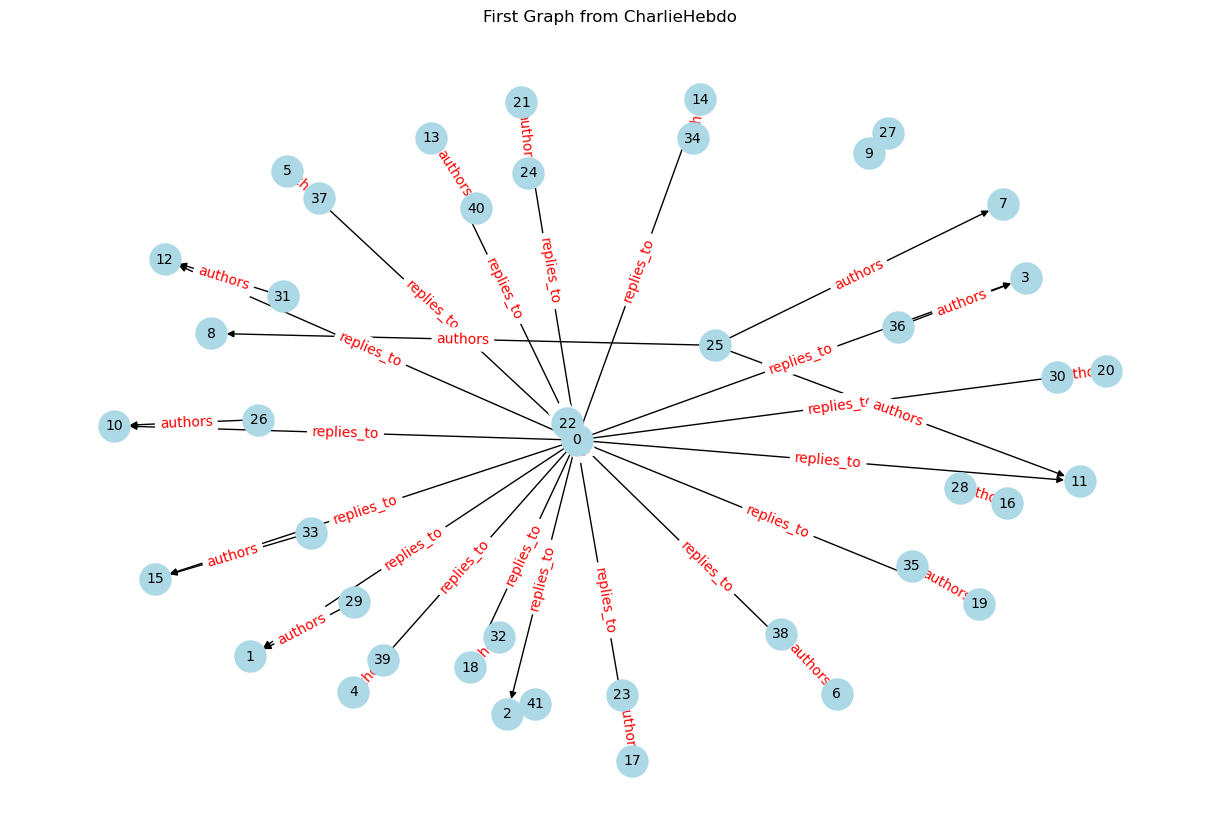

In [14]:
pickle_path = "/Users/andrewxu/Documents/Yale College/Year 2/FA24/CPSC 483/Graph-FakeNewsNet/pheme_graphs/charliehebdo-all-rnr-threads_graphs.pkl"  # Replace with your pickle file path
graphs = load_graphs_from_pickle(pickle_path)

# Visualize the first graph in the file
if graphs:
    print(f"Loaded {len(graphs)} graphs from {pickle_path}")
    visualize_graph(graphs[1000], title="First Graph from CharlieHebdo")
else:
    print("No graphs found in the pickle file.")

In [15]:
def inspect_graph(graph):
    # Inspect tweet node attributes
    print("Tweet Node Features:")
    print(graph["tweet"].x)  # Print numerical features for tweet nodes
    print("Tweet Node Texts:")
    print(graph["tweet"].text)  # Print text attributes for tweet nodes

    # Inspect user node attributes
    print("\nUser Node Features:")
    print(graph["user"].x)  # Print numerical features for user nodes

Loaded 2079 graphs from /Users/andrewxu/Documents/Yale College/Year 2/FA24/CPSC 483/Graph-FakeNewsNet/pheme_graphs/charliehebdo-all-rnr-threads_graphs.pkl


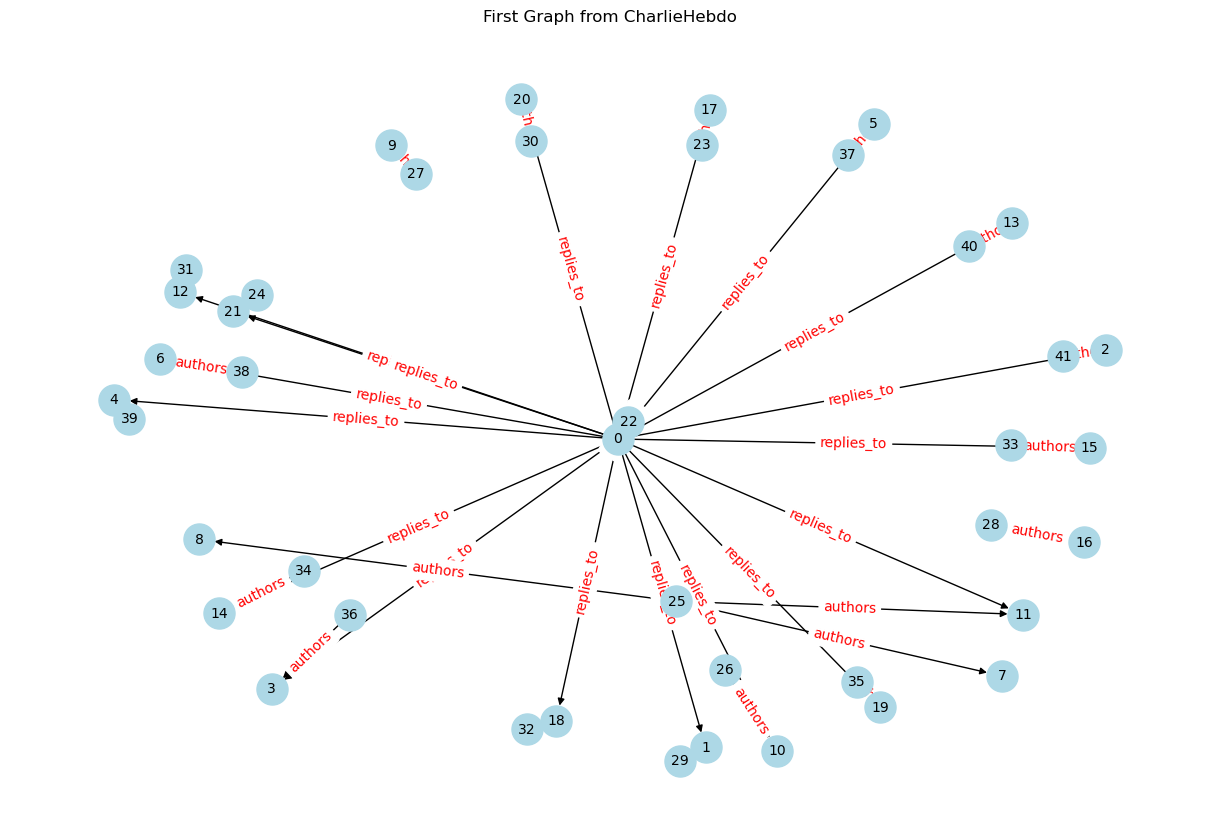

Tweet Node Features:
tensor([[667., 559.],
        [  0.,   0.],
        [  2.,   0.],
        [  0.,   0.],
        [  0.,   1.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  1.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  1.,   1.],
        [  0.,   0.],
        [  1.,   0.],
        [  0.,   0.],
        [  2.,   0.],
        [  1.,   1.],
        [  1.,   2.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.],
        [  0.,   0.]])
Tweet Node Texts:
['FUCK THE TERRORIST IN PARIS I BREAK THERE FUCKING NECKS', '@the_ironsheik make them humble', 'Thank you based Sheik @the_ironsheik @Fyrasec http://t.co/nbwrEb0CLj', '@the_ironsheik The Sheiky Baby has spoken.', '@the_ironsheik sorry to be the grammar police here, but it\'s break "their" fucking necks with my old, decrepit hands.', "@the_ironsheik HELL YEAH!! YOU'RE THE BEST IRON SHEIK! FUCK THEM ALL UP!!!!!!!!!!!", '@the_ironsheik MAIGRET et LE FANTOME film avec Bruno C

In [16]:
pickle_path = "/Users/andrewxu/Documents/Yale College/Year 2/FA24/CPSC 483/Graph-FakeNewsNet/pheme_graphs/charliehebdo-all-rnr-threads_graphs.pkl"  # Replace with your pickle file path
graphs = load_graphs_from_pickle(pickle_path)

# Visualize the first graph in the file
if graphs:
    print(f"Loaded {len(graphs)} graphs from {pickle_path}")
    visualize_graph(graphs[1000], title="First Graph from CharlieHebdo")
    inspect_graph(graphs[1000])
else:
    print("No graphs found in the pickle file.")